In [91]:
import os, sys # os stands for "operating system" and includes read/write routines etc. 
import mkl
mkl.set_num_threads(10)
import seaborn as sns
import numpy as np # by far the most used library for everyday computation
from scipy import io # this is for importing Matlab data files
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our |plotting is done with plt
from src import utils # this is our own library of functions
from sklearn.metrics import accuracy_score
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %matplotlib notebook # if you need to zoom into a figure, this is the "interactive" mode of IPython
#sys.path.insert(0, '/home/mano/Documents/Profesional Projects/Suite2p/suite2p/') #linux import
sys.path.insert(0,r'C:\Users\WinDesktopMP\Documents\suite2p')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
exp_db = []
exp_db = utils.add_exp(exp_db, 'TX80', '2022_06_17', '1')
exp_db

[{'mname': 'TX80', 'datexp': '2022_06_17', 'blk': '1'}]

In [3]:
iexp       = 0
dual_plane = 1
timeline   = utils.load_exp_info(exp_db[iexp])
spks, xpos, ypos, iplane, stat = utils.load_neurons(exp_db[iexp], dual_plane=True,baseline=True)

(20,)
plane 0,  neurons: 1098
plane 1,  neurons: 4180
plane 2,  neurons: 5125
plane 3,  neurons: 4101
plane 4,  neurons: 2319
plane 5,  neurons: 2326
plane 6,  neurons: 5271
plane 7,  neurons: 4153
plane 8,  neurons: 4344
plane 9,  neurons: 2990
plane 10,  neurons: 684
plane 11,  neurons: 2519
plane 12,  neurons: 2965
plane 13,  neurons: 2655
plane 14,  neurons: 1535
plane 15,  neurons: 1882
plane 16,  neurons: 3598
plane 17,  neurons: 2869
plane 18,  neurons: 2918
plane 19,  neurons: 1649
total neurons 59181


# Plot neuron positions

Text(0, 0.5, 'Y position (um)')

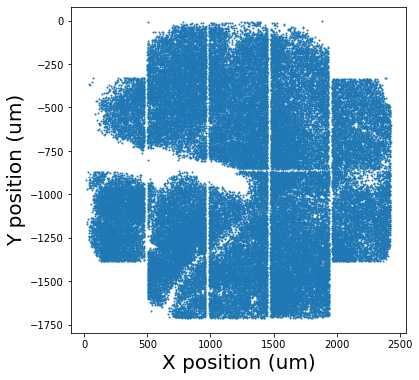

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(xpos, -ypos, s = 1)
plt.xlabel('X position (um)', fontsize=20)
plt.ylabel('Y position (um)', fontsize=20)

In [5]:
neurons_atframes, subset_stim = utils.get_neurons_atframes(timeline,spks)

In [6]:
avg_response, csig = utils.get_tuned_neurons(neurons_atframes, subset_stim)

In [7]:
csig.mean()


0.100595206

# Visualize tuned neurons

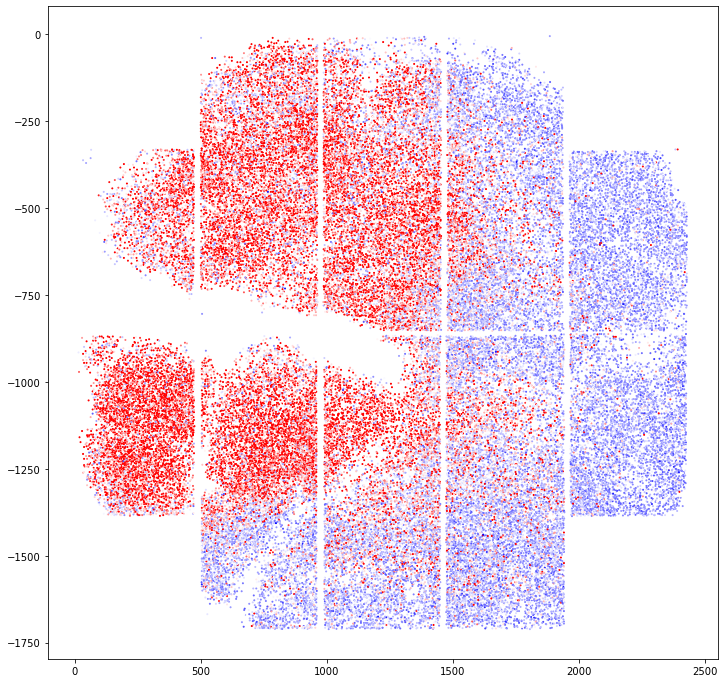

In [8]:
plt.figure(figsize=(12,12))
plt.scatter(xpos, -ypos, c = csig, cmap = 'bwr', vmax = .2, s = 1)

# Get 8x4 stimuli for the Dprime decoder
* in the session 'TX80', '2022_06_17', '1' we used a combined stimuli from nat30k and textures 8x4, this block of code retrieve only the 8x4 repeats

In [9]:
n_cat = 8
samples_per_cat = 4
total_samples = n_cat * samples_per_cat
_, nc = np.unique(subset_stim, return_counts = True)
nc = nc[:total_samples]
nreps = np.min(nc)
for exemplar in range(total_samples):
    if exemplar == 0:
        idx_4x8 = np.expand_dims(np.where(subset_stim==exemplar+1)[0][:nreps],axis=0)
    else:
        idx_4x8 = np.append(idx_4x8, np.expand_dims(np.where(subset_stim==exemplar+1)[0],axis=0),axis=0)
cats_idx = np.arange(0, total_samples, samples_per_cat)
print(f"{cats_idx.shape[0]} categories, {idx_4x8.shape[0]} exemplars, {idx_4x8.shape[1]} repeats")

8 categories, 32 exemplars, 98 repeats


In [10]:
categories_dict = {
    "0":"leaves",
    "1":"circles",
    "2":"dryland",
    "3":"rocks",
    "4":"tiles",
    "5":"squares",
    "6":"round leaves",
    "7":"paved"}

In [107]:
decoder_stimuli = np.zeros((8, neurons_atframes.shape[0], idx_4x8.shape[1]))
train_category = 0  # always even, since the even categories are the postive texture (rewarded) for each pair 
train_texture = 0 
train_idx = train_category * samples_per_cat
for exemplar in range(8):
    decoder_stimuli[exemplar] = neurons_atframes[:, idx_4x8[train_idx+exemplar]]
X_train = decoder_stimuli[:, :, ::2] #Even repeats for training
X_test = decoder_stimuli[:, :, 1::2] #Odd repeats for testing
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (8, 59181, 49)
X_test shape: (8, 59181, 49)


# Dprime calculation 
* this a block by block calculation of the last section, basically we use the category pair leaves/circles, training with the exemplar pair 0

In [108]:
from src.utils import DprimeDecoder
decoder = DprimeDecoder(samples_per_category=samples_per_cat, train_exemplar=train_texture, threshold=0.5)
decoder.fit(X_train,iplane,zstack=2)
spop = decoder.test(X_test, iplane, zstack=2)

In [109]:

ix1 = (decoder.dprime_[decoder.train_exemplar] > decoder.threshold) * (iplane >= 10)  # the last ten ROIs are in the top plane
ix2 = (-decoder.dprime_[decoder.train_exemplar] > decoder.threshold) * (iplane >= 10)
# spop is the decoder applied to test trials
spop_train = X_train[:, ix1, :].mean(1) - X_train[:, ix2, :].mean(1)

In [110]:
spop_train = spop_train.reshape(2,-1)
y= np.concatenate((np.ones(spop_train.shape[1]),np.zeros(spop_train.shape[1])))

find the treshold:

In [111]:
spop_train = spop_train.reshape(-1,1)
train_min = spop_train.min()
train_max = spop_train.max()
threshold = np.arange(train_min,train_max,0.0001)
trsh = []
scre = []
for t in threshold:
    pred = spop_train>t
    acc = accuracy_score(y,pred) * 100
    trsh.append(t)
    scre.append(acc)
trsh = np.array(trsh)
scre = np.array(scre)
amax = np.argmax(scre)
trsh[amax]

-0.010627941267353724

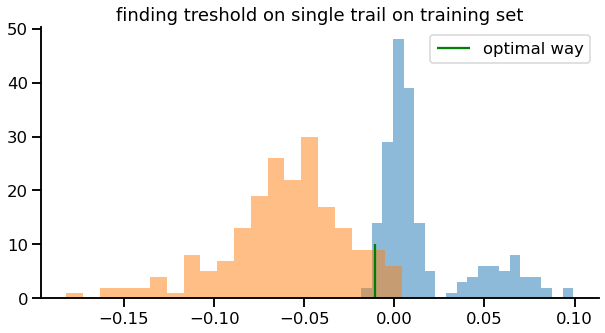

In [112]:
spop_train = spop_train.reshape(2,-1)
plt.figure(figsize=(10,5))
plt.hist(spop_train[0],bins=20,alpha=0.5)
plt.hist(spop_train[1],bins=20,alpha=0.5)
plt.vlines(x=trsh[amax],ymin=0,ymax=10, color='g', label = 'optimal way') # svm tresh
plt.title('finding treshold on single trail on training set')
plt.legend()
sns.despine()

3191 neurons above d-prime = 0.5 for train exemplar: 0 from category: leaves


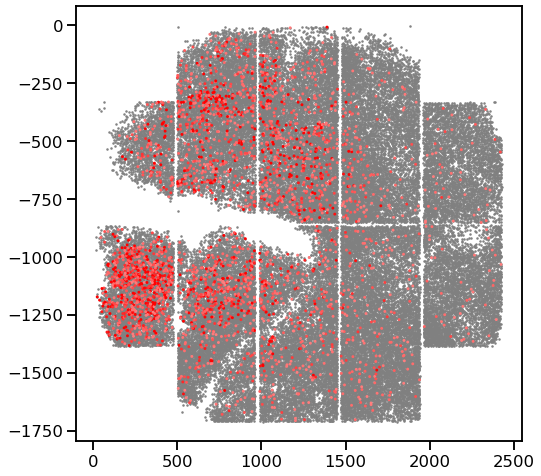

In [113]:
plt.figure(figsize=(8,8))
plt.scatter(xpos, -ypos, c = 'gray', s = 1)
plt.scatter(xpos[decoder.neurons_abvtresh_], -ypos[decoder.neurons_abvtresh_], c = decoder.dprime_[0,decoder.neurons_abvtresh_], cmap = 'bwr', vmax = 1, vmin=-1, s = 2);
print(f'{decoder.neurons_abvtresh_.sum()} neurons above d-prime = 0.5 for train exemplar: {train_category} from category: {categories_dict[str(train_category)]}')

In [114]:
ix1 = (decoder.dprime_[decoder.train_exemplar] > decoder.threshold) * (iplane >= 10)  # the last ten ROIs are in the top plane
ix2 = (-decoder.dprime_[decoder.train_exemplar] > decoder.threshold) * (iplane >= 10)
# spop is the decoder applied to test trials
spop_test = X_test[:, ix1, :].mean(1) - X_test[:, ix2, :].mean(1)
pred = np.mean(spop_test, -1) > trsh[amax]
y = np.concatenate((np.ones(samples_per_cat), np.zeros(samples_per_cat)))
scr = accuracy_score(y, pred) * 100
scr

100.0

# doing it again but for all category pairs, and each training texture pair:
* Use even repeats (X_train) to fit the decoder, and find the optimal classification boundary
* Use the boundary to classify the repeat average of the odd trials (`np.mean(self.spop_, -1) > self.clf_boundary_`)

In [102]:
train_category = np.arange(0,8,2)  # always even, since the even categories are the postive texture (rewarded) for each pair , and it takes automatically the next category as a the negative one.
train_texture = np.arange(4)
accurracy = []
for category in train_category:
    for texture in train_texture:
        decoder_stimuli = np.zeros((8, neurons_atframes.shape[0], idx_4x8.shape[1]))
        train_idx = category * samples_per_cat
        for exemplar in range(8):
            decoder_stimuli[exemplar] = neurons_atframes[:, idx_4x8[train_idx+exemplar]]
        X_train = decoder_stimuli[:, :, ::2] #Even repeats for training
        X_test = decoder_stimuli[:, :, 1::2] #Odd repeats for testing
        decoder = DprimeDecoder(samples_per_category=samples_per_cat, train_exemplar=texture, threshold=0.5)
        decoder.fit(X_train, iplane, zstack=2)
        decoder.test(X_test, iplane, zstack=2)
        acc = decoder.score()
        print(f" category: {categories_dict[str(category)]}, exemplar trained: {texture}, accuracy: {acc}")
        accurracy.append(acc)
accurracy = np.array(accurracy).reshape(4,4)

 category: leaves, exemplar trained: 0, accuracy: 100.0
 category: leaves, exemplar trained: 1, accuracy: 100.0
 category: leaves, exemplar trained: 2, accuracy: 87.5
 category: leaves, exemplar trained: 3, accuracy: 100.0
 category: dryland, exemplar trained: 0, accuracy: 75.0
 category: dryland, exemplar trained: 1, accuracy: 62.5
 category: dryland, exemplar trained: 2, accuracy: 87.5
 category: dryland, exemplar trained: 3, accuracy: 75.0
 category: tiles, exemplar trained: 0, accuracy: 100.0
 category: tiles, exemplar trained: 1, accuracy: 100.0
 category: tiles, exemplar trained: 2, accuracy: 100.0
 category: tiles, exemplar trained: 3, accuracy: 100.0
 category: round leaves, exemplar trained: 0, accuracy: 87.5
 category: round leaves, exemplar trained: 1, accuracy: 100.0
 category: round leaves, exemplar trained: 2, accuracy: 100.0
 category: round leaves, exemplar trained: 3, accuracy: 100.0


In [106]:
category_pairs = ["leaves/circles","dryland/rocks","tiles/squares","round leaves/paved"]
for cat in range(4):
    acc = accurracy[cat].mean(-1)
    print(f" category: {category_pairs[cat]}, average accuracy: {acc}")

 category: leaves/circles, average accuracy: 96.875
 category: dryland/rocks, average accuracy: 75.0
 category: tiles/squares, average accuracy: 100.0
 category: round leaves/paved, average accuracy: 96.875


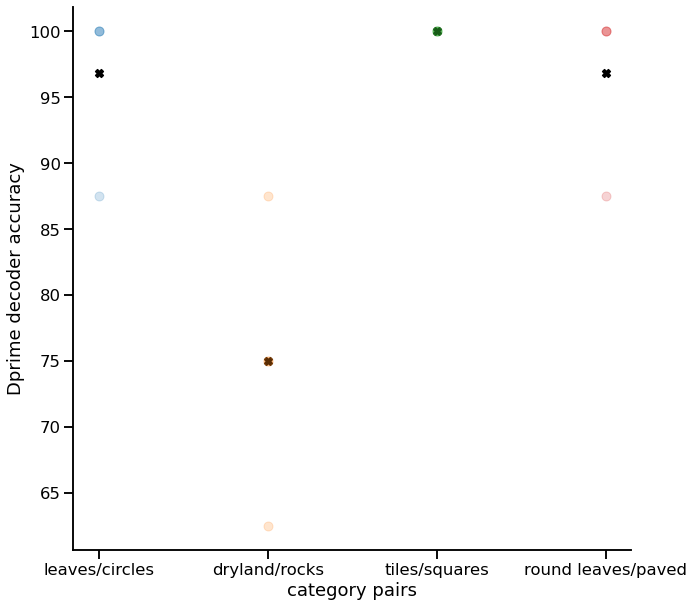

In [104]:
import seaborn as sns
sns.set_context("talk")
plt.figure(figsize=(10,10))
for cat in range(4):
    y = accurracy[cat,:]
    x = np.ones(4) * cat
    plt.plot(x,y, "o", alpha = 0.2)
    plt.scatter(x[0],y.mean(),marker="X",c="k",s=60)
plt.ylabel("Dprime decoder accuracy")
plt.xticks([0,1,2,3],["leaves/circles", "dryland/rocks", "tiles/squares", "round leaves/paved"])
plt.xlabel("category pairs");
sns.despine()